## Exploring the metrics to detect anomalies

Some of the functions of the objects below might be deprecated.

For instance the variable `obs.full_concatenated_df` used to represent the very segmented intervals - due to the NaN ( = 32670) values. But no longer since only the missing values for one sensor are considered.

In [56]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from observation import Observation

reactor_site = "A1" #[site+tranche for site in ["A","B","C","D","E","F","G","H"] for tranche in ["1","2"]] + ["B3","B4","F3","F4"]

suffixes = [
"DEB1-1","DEB1-2","DEB1-3","DEB1-4", # Débit de fuite au joint 1 (Gamme Large)
"DEB2-1","DEB2-2","DEB2-3","DEB2-4", # Débit de fuite au joint 1 (Gamme Étroite)
"DEB3-1","DEB3-2","DEB3-3","DEB3-4","DEB3-5", # Débit d'injection au joint
"PUI-",  # Puissance thermique moyenne
"PRE-",  # Pression
"TEM1-", # Température ligne d'injection aux joints (en * Celsius)     ### A rapprocher de DEB3
"TEM2-", # Température fuites joint 1
"TEM3-1","TEM3-2","TEM3-3","TEM3-4",# Température eau joint 1 - 051PO ### A rapprocher de DEB1 DEB2
"VIT-1","VIT-2","VIT-3","VIT-4"# Vitesse de rotation
] 

PATH = "../../Data/GMPP_IRSDI/"
obs = Observation(PATH,reactor_site,suffixes,verbose=1)
intervals = obs.full_concatenated_df

print(str(len(obs.df))+" : Initial length of full df")
print(str(np.sum([len(df) for df in intervals]))+" : New length of all selected intervals")

Loading in memory 25 observations...
Concatenation...
Changing isolated wrong values...
Forward Filling...
Backward Filling...
525887 : Initial length of full df
140 : New length of all selected intervals


From : 20/12/2006
To   : 21/12/2006


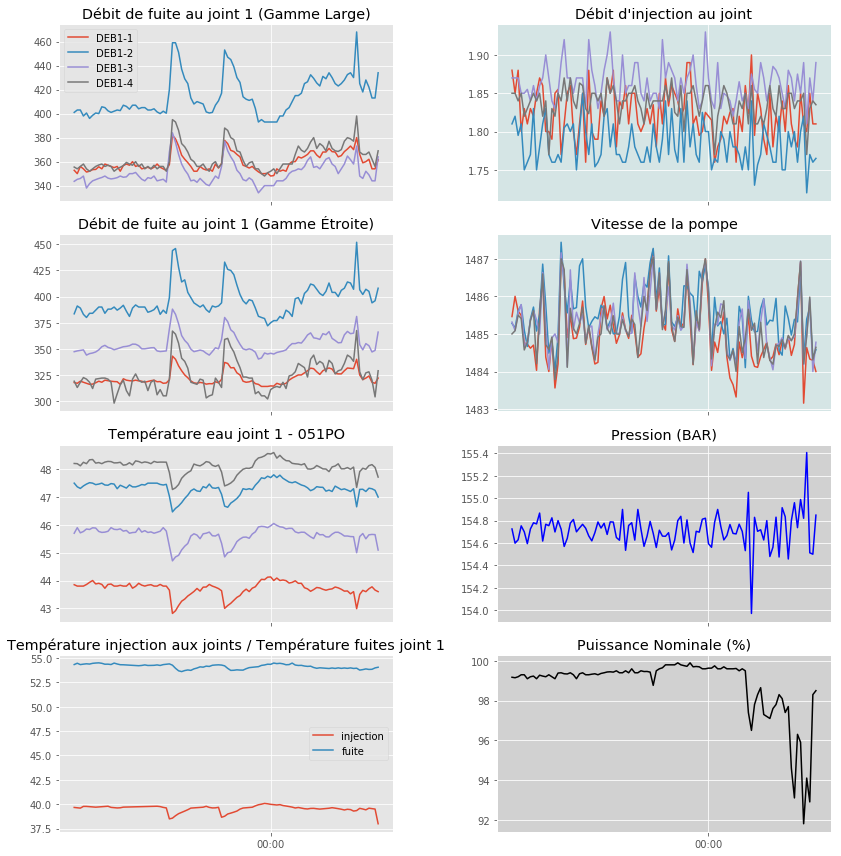

In [60]:
from insight import plot_all_tight

plot_all_tight(obs.full_concatenated_df.iloc[50450:50550])

## Grouping and visualizing variables

The groups can be found in `insight.py`

In [ ]:
from ipywidgets import interact,BoundedIntText,Button,ToggleButton,IntSlider
from IPython.display import display
from matplotlib.dates import HourLocator, DateFormatter
plt.style.use('ggplot')
import pandas as pd
from insight import Plot
from constants import *

def interact_with_intervals(intervals):
    if(len(intervals)==0):
        print("No such interval")
        return
    
    plot = Plot(intervals)
    
    interval_widget = BoundedIntText(value=len(intervals)/2,min=0,max=len(intervals)-1,step=1,description='Interval number',disabled=False)
    btn_up = Button(description='Up',disabled=False,button_style='success',tooltip='Increase interval number by 1')
    btn_down = Button(description='Down',disabled=False,button_style='warning', tooltip='Decrease interval number by 1')
    
    toggle_widget = ToggleButton(
        value=False,
        description='Tight Layout',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        icon='check'
    )
    display(btn_up)
    display(btn_down)

    def increase(t):
        interval_widget.value+=1
    def decrease(t):
        interval_widget.value-=1

    btn_up.on_click(increase)
    btn_down.on_click(decrease)

    interact(plot.plot_all,i=interval_widget, tight_boolean=toggle_widget);
    

In [ ]:
interact_with_intervals(intervals)

# Scoring the anomalies

## Filtering

- We might want to filter the anomalies and only consider the intervals where the power is **above 80 during the whole interval**.

In [ ]:
power_above_80 = lambda df: ((df[pui]<80).sum()==0).any()
print(str(np.sum([len(df) for df in [df for df in intervals if power_above_80(df)]]))+" : Intervals where the power stays above 80% ")

## Metrics for scoring anomalies

- One sensor has high variance in the period.
- All sensors have, on average, high variance in the period.
- One sensor has high variance **on a fixed length window**, to locate small windows with high variance.
- One sensor exhibits a **sudden big jump**.
- The **median of the fft** of one sensor is high.

In [18]:
idx1 = np.argsort([df[deb1].var(axis=0).max() for df in intervals])[::-1]
idx2 = np.argsort([df[deb1].var(axis=0).mean() for df in intervals])[::-1]
idx3 = np.argsort([df[deb1].rolling(20).var().max(axis=0).max() for df in intervals])[::-1]
idx4 = np.argsort([df[deb1].diff().max().max() for df in intervals])[::-1]
idx5 = np.argsort([np.mean(np.abs(np.fft.fft(df[deb1],axis=0)),axis=0).max() for df in intervals])[::-1]
idx6 = np.argsort([np.median(np.abs(np.fft.fft(df[deb1],axis=0)),axis=0).max() for df in intervals])[::-1]

def interact_with_index(intervals, idx):
    interact_with_intervals([intervals[i] for i in idx])

In [20]:
interact_with_index(intervals,idx4)

In [26]:
def filter_and_sort(intervals, df_score, df_filter=lambda df:True):
    idx_filtered = [i for i in range(len(intervals)) if df_filter(intervals[i])] 
    scores = [df_score(intervals[i]) for i in idx_filtered]
    arg_sorted_scores = np.argsort(scores)[::-1]
    idx_sorted = [idx_filtered[i] for i in arg_sorted_scores]
    scores = [scores[i] for i in arg_sorted_scores]
    return scores, idx_sorted

In [47]:
f1 = lambda df: df[deb1].var(axis=0).max()
f2 = lambda df: df[deb1].var(axis=0).mean()
f3 = lambda df: df[deb1].rolling(20).var().max(axis=0).max()
f4 = lambda df: df[deb1].diff().max().max()
f5 = lambda df: np.median(np.abs(np.fft.fft(df[deb1],axis=0)),axis=0).max()

s1, idx_1 = filter_and_sort(intervals, f1, power_above_80)
s2, idx_2 = filter_and_sort(intervals, f2, power_above_80)
s3, idx_3 = filter_and_sort(intervals, f3, power_above_80)
s4, idx_4 = filter_and_sort(intervals, f4, power_above_80)
s5, idx_5 = filter_and_sort(intervals, f5, power_above_80)

In [73]:
interact_with_index(idx_1)

<hr>
# Detecting oscillation pattern
### Using a simple variance sliding window approach

If there is an oscillation pattern, there exists a window of a given size (w_length), such that there is an oscillation pattern in it.
In that window, the variance is high for every smaller intervals inside that window.

So it amounts to choosing the **max of the sliding mean of the sliding variance** of these windows for each interval.

In [27]:
w_1 = 3; w_2 = 40
filter6 = lambda df: len(df[deb1])>w_1+w_2
f6 = lambda df: df[deb1].rolling(w_1).var().rolling(w_2).median().max(axis=0).max()

s6, idx_6 = filter_and_sort(intervals, f6,filter6)

In [29]:
interact_with_index(intervals,idx_6)

### Fast fourier transform to identify one type of anomalies 

In [46]:
w_1 = 100
filter7 = lambda df: len(df[deb1])>w_1

def f7(df):
    fft_values = np.abs(np.fft.fft(df[deb1[0]].iloc[:100].values,axis=0))
    arg_max_fft = np.argmax(fft_values[1:50]) + 1
    return fft_values[int(arg_max_fft/len(deb1)),arg_max_fft%len(deb1)]*np.sqrt(arg_max_fft)

s7, idx_7 = filter_and_sort(intervals, f7,filter7)

In [49]:
interact_with_index(intervals,idx_7)

In [34]:
#plot_fft_deb1(intervals[100],ylim=(0,600))
#plot_fft_deb1(intervals[idx3[12]],ylim=(0,600)) ## The problem is visible
#plot_fft_deb1(intervals[idx3[17]],ylim=(0,600))
from ipywidgets import interact,BoundedIntText,Button,ToggleButton,IntSlider
from IPython.display import clear_output
%matplotlib inline
import mpld3
mpld3.enable_notebook()
def interact_fft(intervals):
    if(len(intervals)==0):
        print("No such interval")
        return
    clear_output()
    plot = Plot(intervals)
    
    interval_widget = BoundedIntText(value=len(intervals)/2,min=0,max=len(intervals)-1,step=1,description='Interval number',disabled=False)
    interval_widget2 = BoundedIntText(value=len(intervals)/2-1,min=0,max=len(intervals)-1,step=1,description='Interval number',disabled=False)
 
    width_widget = IntSlider(value=60,min=10,max=len(intervals),step=1,description='Width',disabled=False)
    offset_widget = IntSlider(value=0,min=-1,max=50,step=5,description='Offset',disabled=False)
 
    interact(plot.plot_fft,i=interval_widget, j=interval_widget2,w_length =width_widget,offset = offset_widget);

#idx4 - 6 7 9 15
#idx4 - 16


interact_fft(intervals)

In [35]:
print(idx_6[1])
print(idx_6[2])
print(idx_6[4])
#npn.sqrt(argmax())


61
490
399


## Anomalies detection with regression

The anomalies might as well be explained with a linear regression

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

reg = LinearRegression()
reg_multi = MultiOutputRegressor(reg)

predictive_features = pre+pui+tmp+tmp2+deb3
X_ = np.concatenate([df[predictive_features].values for df in intervals],axis=0)
y_ = np.concatenate([df[deb1].values for df in intervals],axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_,y_,test_size=0.2)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.7892831422334402

Does this score suggest that linear regression is efficient enough ?

In [55]:
reg.fit(X_,y_)
idx6 = np.argsort([reg.score(df[predictive_features].values,df[deb1].values) for df in intervals])

def max_error_regression_df(df):
    absolute_error = np.abs(reg.predict(df[predictive_features].values)-df[deb1].values)
    return np.max(np.max(absolute_error,axis=0))

idx7 = np.argsort([max_error_regression_df(df) for df in intervals])
interact_with_index(idx7) # Doesn't work that well !

## Increasing trend detection

- A **linear regression** gives the **highest slope** for all the sensors.

In [57]:
def max_trend(df):
    #df = df.iloc[int(len(df)/4):int(3*len(df)/4)]
    #w_length = 10
    #df = df[deb1].rolling(w_length).mean().iloc[w_length-1:]
    df = df[deb1]
    reg.fit(np.arange(len(df)).reshape(len(df),-1),df.values)
    return reg.coef_.max()*len(df),deb1[reg.coef_.argmax()]

max_trend_array = [max_trend(df) for df in intervals]
idx8 = np.argsort([max_trend[0] for max_trend in max_trend_array])[::-1]
max_trend_array_sorted = [max_trend_array[i] for i in idx8]
#interact_with_index(idx8) # Doesn't work that well !

We can look up the details of that regression

In [59]:
i = 8
print("Trend value : "+str(max_trend_array_sorted[i][0])+" for sensor : "+str(max_trend_array_sorted[i][1]))

Trend value : 107.796939565 for sensor : DEB1-4


In [58]:
interact_with_index(idx8) # Doesn't work that well !

## Decreasing trend detection

Exactly the same, this time taking the min of the min

In [61]:
def min_trend(df):
    #df = df.iloc[int(len(df)/4):int(3*len(df)/4)]
    #w_length = 10
    #df = df[deb1].rolling(w_length).mean().iloc[w_length-1:]
    df = df[deb1]
    reg.fit(np.arange(len(df)).reshape(len(df),-1),df.values)
    return reg.coef_.max()*len(df),deb1[reg.coef_.argmin()]

min_trend_array = [min_trend(df) for df in intervals]
idx9 = np.argsort([min_trend[0] for min_trend in min_trend_array])
min_trend_array_sorted = [min_trend_array[i] for i in idx9]

In [62]:
i = 8
print("Trend value : "+str(min_trend_array_sorted[i][0])+" for sensor : "+str(min_trend_array_sorted[i][1]))

Trend value : -24.0962009952 for sensor : DEB1-4


In [63]:
interact_with_index(idx9) # Doesn't work that well !

## Pattern matching

In [64]:
import fastdtw as fastdtw
from scipy.spatial.distance import euclidean
#print(sys.version)

In [65]:
fastdtw.fastdtw(np.array([1,3,2,2]),np.array([1,2]),dist=euclidean)

(1.0, [(0, 0), (1, 1), (2, 1), (3, 1)])

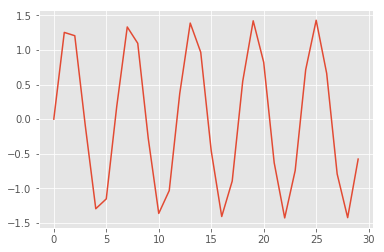

In [66]:
import math
n_osc = 5
n_points = 30
sin_ref = np.sin(np.linspace(0,int(2*math.pi*n_osc),n_points ))
sin_ref = sin_ref/np.sqrt(np.var(sin_ref))
plt.plot(sin_ref)

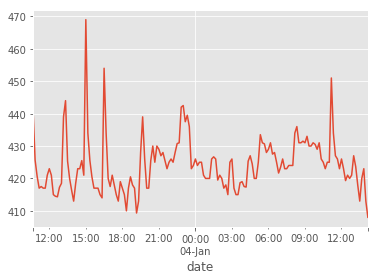

In [67]:
n_points = 30 
series = intervals[idx6[40]][deb1[1]]
roll = series.rolling(n_points)
series_transformed = ((series - roll.mean())/np.sqrt(roll.var())).iloc[n_points-1:]
series.plot()
#series_transformed.plot() # This is normalized

In [68]:
[fastdtw.fastdtw(sin_ref,series_transformed.values[i*n_points:(i+1)*n_points],dist=euclidean)[0] for i in range(int(len(series_transformed)/n_points))]
#series_transformed.values[i:i+n_points]

[21.41373217811489, 27.89433902833305, 23.932702173732636, 27.99687461791148]

In [69]:
def score_similarity(df):
    if len(df)<40:
        return 100
    n_points = 30
    series = df[deb1[1]]
    roll = series.rolling(n_points)
    series_transformed = ((series - roll.mean())/(1e-5+np.sqrt(roll.var()))).iloc[n_points-1:]
    return min([fastdtw.fastdtw(sin_ref,series_transformed.values[i*n_points:(i+1)*n_points],dist=euclidean)[0] for i in range(int(len(series_transformed)/n_points))])

scores_similarity = [score_similarity(df) for df in intervals]

In [70]:
idx11 = np.argsort(scores_similarity)

In [71]:
interact_with_index(idx11)

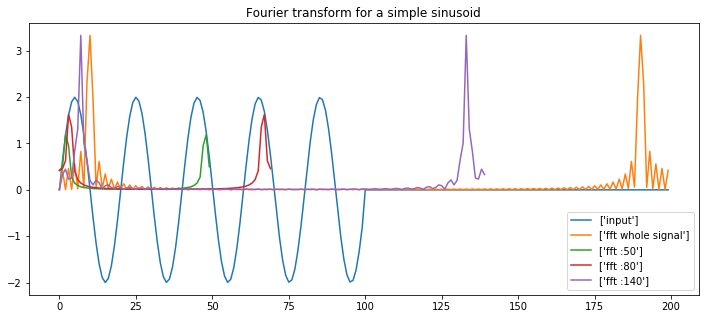

In [44]:
from cmath import *
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
n_osc = 5
n_points = 100
sin_ref = np.concatenate([np.sin(np.linspace(0,int(2*math.pi*n_osc),n_points )),np.zeros(100)])
sin_ref = sin_ref/np.sqrt(np.var(sin_ref))
plt.figure(figsize=(12,5))
plt.plot(sin_ref,label = ["input"])
plt.plot(np.abs(np.fft.fft(sin_ref))/30,label = ["fft whole signal"])
plt.plot(np.abs(np.fft.fft(sin_ref[:50]))/30, label = ["fft :50"])
plt.plot(np.abs(np.fft.fft(sin_ref[:70]))/30, label = ["fft :80"])
#plt.plot(np.abs(np.fft.fft(sin_ref[:80]))/30)
plt.plot(np.abs(np.fft.fft(sin_ref[:140]))/30, label = ["fft :140"])
plt.legend(loc='best')
plt.title('Fourier transform for a simple sinusoid')
#abs(exp(6j))

(0, 800)

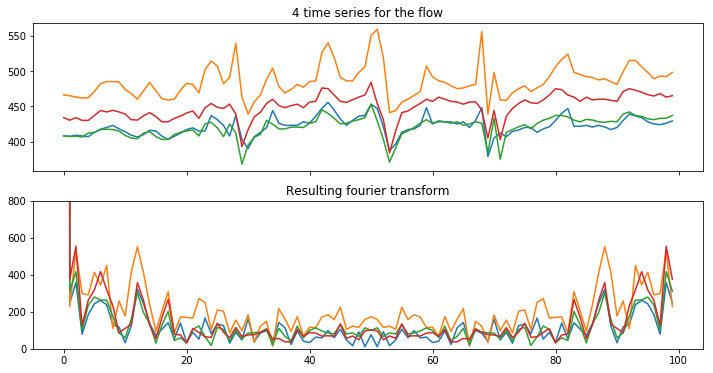

In [42]:
data = obs.full_concatenated_df.iloc[51450:51550]
#data.plot()
fig, axes =  plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)
data = data.values
# offset=40; w_length = 30
data_fft = np.abs(np.fft.fft(data,axis=0))
axes[0].plot(data,label="fft")
axes[0].set_title("4 time series for the flow")
axes[1].plot(data_fft,label="fft")
axes[1].set_title("Resulting fourier transform")
axes[1].set_ylim([0,800])
# plt.plot(osc_fft,label="osc")
# plt.legend()

In [140]:
def iterative_fft(signal, w_length, index):
    current_fft = np.fft.fft(signal[:w_length])
    arange_op = np.exp(2j*pi*np.arange(w_length)/w_length)
    for i in range(index):
        current_fft = (current_fft - sin_ref[i] + sin_ref[w_length+i])*arange_op
    return current_fft

iterative_fft(sin_ref,10,5)import pandas as pd
import numpy as np
from ipywidgets import interact,BoundedIntText,Button,ToggleButton,IntSlider, Dropdown
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from constants import *

class Interaction:
    def __init__(self, intervals):
        self.intervals = intervals
        initial = {"scores": np.zeros(len(self.intervals)),"idx": np.arange(len(self.intervals)),"order":0}
        self.idx_dict = {'Initial':initial} # mettre un index normal de base ...

    def add_idx(self, name, df_score, df_filter=lambda df: True):
        idx_filtered = [i for i in range(len(self.intervals)) if df_filter(self.intervals[i])]
        scores = [df_score(self.intervals[i]) for i in idx_filtered]
        arg_sorted_scores = np.argsort(scores)[::-1]
        idx_sorted = [idx_filtered[i] for i in arg_sorted_scores]
        scores = [scores[i] for i in arg_sorted_scores]
        self.idx_dict[name] = {"scores": scores,
                               "idx": idx_sorted,
                               "order" : len(self.idx_dict)}

    def add_filter(self,name,df_filter):
        idx_filtered = [i for i in range(len(self.intervals)) if df_filter(self.intervals[i])]
        self.idx_dict[name] = {"idx": idx_filtered}

    def interact(self):
        list_dropdown = list(self.idx_dict.keys())
        list_dropdown.sort(key=lambda k:self.idx_dict[k]["order"])
        idx_widget = Dropdown(
            options=list_dropdown,
            value='Initial',
            description='Anomaly type:',
            disabled=False,
            button_style='danger' # 'success', 'info', 'warning', 'danger' or ''
        )

        interval_widget = BoundedIntText(value=0, min=0, max=len(self.intervals) - 1, step=1,
                                         description='Interval number', disabled=False)

        def idx_widget_observe(p):
            if ('value' in p.new):
                interval_widget.max = len(self.idx_dict[p.new['value']]["idx"]) - 1

        idx_widget.observe(idx_widget_observe)
        # A voir... idx_widget  -->> len(self.idx_dict[idx_widget.value]["idx"])

        btn_up = Button(description='Up', disabled=False, button_style='success', tooltip='Increase interval number by 1')
        btn_down = Button(description='Down', disabled=False, button_style='warning', tooltip='Decrease interval number by 1')

        toggle_widget = ToggleButton(
            value=False,
            description='Tight Layout',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            icon='check'
        )
        display(btn_up)
        display(btn_down)

        def increase(t):
            interval_widget.value += 1

        def decrease(t):
            interval_widget.value -= 1

        btn_up.on_click(increase)
        btn_down.on_click(decrease)

        interact(self.plot_all, i=interval_widget, tight_boolean=toggle_widget, name_idx = idx_widget);

    def plot_all(self,i,tight_boolean,name_idx):
        if (type(self.intervals) is pd.DataFrame):
            df = self.intervals
        else:
            df = self.intervals[self.idx_dict[name_idx]["idx"][i]]
        # plt.figure(figsize=(width, height))
        if hasattr(df,"reactor_site"):
            print("Nuclear reactor : "+str(df.reactor_site))
        print("From : " + str(df.index[0].strftime("%d/%m/%Y"))
              + "\nTo   : " + str(df.index[-1].strftime("%d/%m/%Y")))
        if not tight_boolean:
            width = 10
            height = 20
            fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(width, height), sharex=True)
        else:
            width = 12
            height = 12
            fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(width, height), sharex=True)
            axes = [axes[int(i % 4), int(i / 4)] for i in range(8)]
        [d1, d2, d3, d4] = axes[0].plot(df[deb1])
        axes[0].legend([d1, d2, d3, d4], deb1, loc='best')
        axes[0].set_title("Débit de fuite au joint 1 (Gamme Large)")
        axes[1].plot(df[deb2])
        axes[1].set_title("Débit de fuite au joint 1 (Gamme Étroite)")
        axes[2].plot(df[tmp])
        axes[2].set_title("Température eau joint 1 - 051PO")

        [t1,t2] = axes[3].plot(df[tmp2])
        axes[3].legend([t1, t2], ["injection","fuite"], loc='best')
        axes[3].set_title("Température injection aux joints / Température fuites joint 1")

        axes[4].plot(df[deb3])
        axes[4].set_title("Débit d'injection au joint")
        axes[4].set_facecolor("#d5e5e5")
        axes[5].plot(df[vit])
        axes[5].set_title("Vitesse de la pompe")
        axes[5].set_facecolor("#d5e5e5")

        axes[6].plot(df[pre], 'b')
        axes[6].set_title("Pression (BAR)")
        axes[6].set_facecolor("#d1d1d1")
        axes[7].plot(df[pui], 'k')
        axes[7].set_title("Puissance Nominale (%)")
        axes[7].set_facecolor("#d1d1d1")

        axes[0].get_xaxis().set_ticks([])
        hour_locator = HourLocator([0, 12])
        axes[0].xaxis.set_major_locator(hour_locator)
        axes[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))

        plt.tight_layout()
        plt.show()


array([ 1.50392050 +0.00000000e+00j,  1.38056304 -5.82997488e+00j,
        1.40501062 -2.09052765e+00j,  1.40842374 -1.06543505e+00j,
        1.40943131 -4.71449805e-01j,  1.40967989 +8.66807988e-16j,
        1.40943131 +4.71449805e-01j,  1.40842374 +1.06543505e+00j,
        1.40501062 +2.09052765e+00j,  1.38056304 +5.82997488e+00j])

In [139]:
np.fft.fft(sin_ref[5:w_length+5])

array([ 1.50392050 +0.00000000e+00j,  1.38056304 -5.82997488e+00j,
        1.40501062 -2.09052765e+00j,  1.40842374 -1.06543505e+00j,
        1.40943131 -4.71449805e-01j,  1.40967989 +4.44089210e-16j,
        1.40943131 +4.71449805e-01j,  1.40842374 +1.06543505e+00j,
        1.40501062 +2.09052765e+00j,  1.38056304 +5.82997488e+00j])

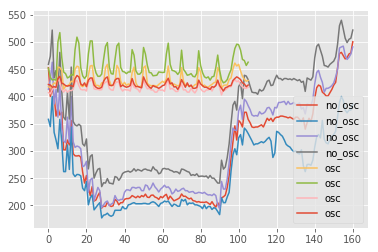

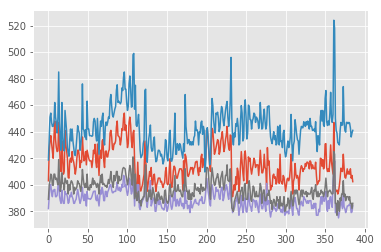

In [193]:
no_osc = intervals[idx_6[3]][deb1].values
osc = intervals[idx_6[4]][deb1].values
test = intervals[idx6[40]][deb1].values
plt.plot(no_osc,label="no_osc")
plt.plot(osc,label="osc")
plt.legend()
plt.show()
plt.plot(test,label="test")
plt.show()

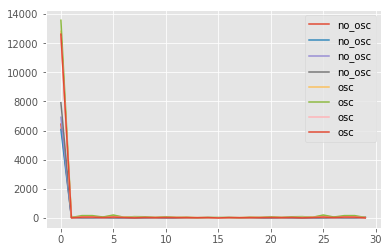

In [178]:
offset=40; w_length = 30
no_osc_fft = np.abs(np.fft.fft(no_osc[offset:offset+w_length],axis=0))
osc_fft = np.abs(np.fft.fft(osc[offset:offset+w_length],axis=0))
plt.plot(no_osc_fft,label="no_osc")
plt.plot(osc_fft,label="osc")
plt.legend()

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
insight.py
@author: edouardm
"""
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import pandas as pd
import numpy as np
from constants import *

class Plot:
    def __init__(self,list_df):
        self.list_df = list_df

    def plot_all(self,tight_boolean, i):
        if (type(self.list_df) is pd.DataFrame):
            df = self.list_df
        else:
            df = self.list_df[i]
        # plt.figure(figsize=(width, height))
        if hasattr(df,"reactor_site"):
            print("Nuclear reactor : "+str(df.reactor_site))
        print("From : " + str(df.index[0].strftime("%d/%m/%Y"))
              + "\nTo   : " + str(df.index[-1].strftime("%d/%m/%Y")))
        if not tight_boolean:
            width = 10
            height = 20
            fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(width, height), sharex=True)
        else:
            width = 12
            height = 12
            fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(width, height), sharex=True)
            axes = [axes[int(i % 4), int(i / 4)] for i in range(8)]
        [d1, d2, d3, d4] = axes[0].plot(df[deb1])
        axes[0].legend([d1, d2, d3, d4], deb1, loc='best')
        axes[0].set_title("Débit de fuite au joint 1 (Gamme Large)")
        axes[1].plot(df[deb2])
        axes[1].set_title("Débit de fuite au joint 1 (Gamme Étroite)")
        axes[2].plot(df[tmp])
        axes[2].set_title("Température eau joint 1 - 051PO")

        [t1,t2] = axes[3].plot(df[tmp2])
        axes[3].legend([t1, t2], ["injection","fuite"], loc='best')
        axes[3].set_title("Température injection aux joints / Température fuites joint 1")

        axes[4].plot(df[deb3])
        axes[4].set_title("Débit d'injection au joint")
        axes[4].set_facecolor("#d5e5e5")
        axes[5].plot(df[vit])
        axes[5].set_title("Vitesse de la pompe")
        axes[5].set_facecolor("#d5e5e5")

        axes[6].plot(df[pre], 'b')
        axes[6].set_title("Pression (BAR)")
        axes[6].set_facecolor("#d1d1d1")
        axes[7].plot(df[pui], 'k')
        axes[7].set_title("Puissance Nominale (%)")
        axes[7].set_facecolor("#d1d1d1")

        axes[0].get_xaxis().set_ticks([])
        hour_locator = HourLocator([0, 12])
        axes[0].xaxis.set_major_locator(hour_locator)
        axes[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))

        plt.tight_layout()
        plt.show()

    def plot_fft(self,i,j,w_length,offset,**kargs):
        fig, axes = plt.subplots(2, 2, figsize=(12, 6))
        df_s = [self.list_df[i], self.list_df[j]]
        if(offset!=-1):
            df_s = [df.iloc[offset:offset+w_length] for df in df_s]
        for k,df in enumerate(df_s):
            fft_df = pd.DataFrame(index=range(1,df.shape[0]), data=np.abs(np.fft.fft(df[deb1], axis=0))[1:], columns=deb1)
            axes[k, 0].plot(df[deb1].values)
            fft_df.plot(ax=axes[k,1], **kargs)
        plt.tight_layout()
        plt.show()

In [52]:
df = intervals[100]
np.abs(np.fft.fft(df[deb1].iloc[:100].values,axis=0))[:30].shape

(30, 4)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

reg = LinearRegression()
reg_multi = MultiOutputRegressor(reg)

def max_trend(df):
    #df = df.iloc[int(len(df)/4):int(3*len(df)/4)]
    #w_length = 10
    #df = df[deb1].rolling(w_length).mean().iloc[w_length-1:]
    df = df[deb1]
    reg.fit(np.arange(len(df)).reshape(len(df),-1),df.values)
    return reg.coef_.max()*len(df),deb1[reg.coef_.argmax()]

max_trend_array = [max_trend(df) for df in intervals]
idx8 = np.argsort([max_trend[0] for max_trend in max_trend_array])[::-1]
max_trend_array_sorted = [max_trend_array[i] for i in idx8]
#interact_with_index(idx8) # Doesn't work that well !

In [140]:
min_rolling_slope(intervals[idx_6[3]])

(-8.5355728302171681, 3, 1)

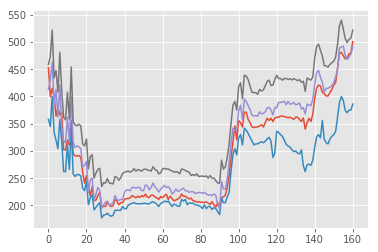

In [131]:
plt.plot(intervals[idx_6[3]][deb1].values)